##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Get started with image generation - REST API

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_imagen_rest.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

The Imagen models are Google's highest quality text-to-image models, featuring a number of new and improved capabilities. Imagen models can do the following:

* Generate images with fine detail, rich lighting, and few distracting artifact
* Understand prompts written in natural language
* Generate images in a wide range of formats and styles
* Render text effectively

You can choose from a range of available Imagen models:
* Imagen 4 (`imagen-4.0-generate-001`) is the new stadard model you should use to generate.
* Imagen 4 Ultra (`imagen-4.0-ultra-generate-001`) is the best Imagen model, generating even finer images and is especially good at generating images with text. Note that it can only generate one image at a time.
* Imagen 4 Fast (`imagen-4.0-fast-generate-001`) is a faster model and generates at a lower cost compared to Imagen 4 and Ultra. See the [pricing page](https://ai.google.dev/gemini-api/docs/pricing#imagen-4) for details.
* Imagen 3 (`imagen-3.0-generate-002`) is the previous generation model. It's still available in case you need to rerun old prompts, but it is recommended to use the 4th generation models now.

This notebook is using the [REST API](https://ai.google.dev/api/generate-content). For the Python SDK, check out the [Get Started with Imagen](../quickstarts/Get_started_imagen.ipynb) Python guide.

<!-- Warning Badge -->
<table>
  <tr>
    <!-- Emoji -->
    <td bgcolor="#f5949e">
      <font size=30>⚠️</font>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#f5949e">
      <h3><font color=black>Image generation is a paid-only feature and won't work if you are on the free tier. Check the <a href="https://ai.google.dev/pricing#imagen-4"><font color='#217bfe'>pricing</font></a> page for more details.</font></h3>
    </td>
  </tr>
</table>

## Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`.

In [ ]:
import os

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

## Send Imagen request
In the next code block, you can change the model_name, prompt, and a bunch of parameters. Then the request will be sent by curl.

The model is trained on long captions and will provide best results for longer and more descriptive prompts. Short prompts may result in low adherence and a more random output.

Check the [prompt guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide) for more advices.

The optional parameters are:
* *sampleCount*: How many images will be generated. Default is 4, valid values are 1-4.
* *aspectRatio*: aspect ratio of the images produced. Supported values are 1:1, 3:4, 4:3, 16:9, 9:16. Default is 1:1.
* *personGeneration*: Lets the model generate images with adults. Kids are always blocked. Supported values are "dont_allow" and "allow_adult". Default is "allow_adult".
* *imageSize*: The output resolution of the image, either `1k` (default) or `2k`, for supported models.

A non-visible digital [SynthID](https://deepmind.google/technologies/synthid/) watermark is always added to generated images.

In [ ]:
model_name = "imagen-4.0-generate-001" # @param ["imagen-3.0-generate-002","imagen-4.0-generate-001","imagen-4.0-ultra-generate-001"] {"allow-input":true, isTemplate:true}
prompt = "A hairy bunny in my kitchen playing with a tomato." # @param {type:"string"}
sampleCount = 1 # @param {type:"slider", min:1, max:4, step:1}
aspectRatio = "1:1" # @param ["1:1", "3:4", "4:3", "16:9", "9:16"]
personGeneration = "allow_adult" # @param ["dont_allow", "allow_adult"]
sampleImageSize = "1k" # @param ["1k", "2k"]

In [ ]:
import requests

url = "https://generativelanguage.googleapis.com/v1beta/models/"+model_name+":predict"

headers = {
    'Content-Type': 'application/json',
}

data = {
    "instances": [
        {
            "prompt": prompt
        }
    ],
    "parameters": {
        "sampleCount": sampleCount,
        "personGeneration": personGeneration,
        "aspectRatio": aspectRatio,
        "sampleImageSize": sampleImageSize,
    }
}

response = requests.post(
    f"{url}?key={GOOGLE_API_KEY}",
    headers=headers,
    json=data
)

# Check for errors
if response.status_code != 200:
    print(f"Request failed with status code: {response.status_code}")
    print("Response:", response.text)
else:
    print("Request successful!")

    # Since the response contains the image in bytes64 it can be very long,
    # let's reduce it's length for the sake of this notebook's size
    trimmed_response = response.json()
    trimmed_response["predictions"][0]["bytesBase64Encoded"] = trimmed_response["predictions"][0]["bytesBase64Encoded"][:100]

    print("Response:", trimmed_response)

Request successful!
Response: {'predictions': [{'bytesBase64Encoded': 'iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAAgAElEQVR4nMy9W5IsSY4spgrAPPJUz8yVe39IfnAZXAb3v4grJIUi', 'mimeType': 'image/png'}]}


## Examine the metadata in the response

In [ ]:
# Check the output length
print("Number of predictions: "+str(len(response.json()['predictions'])))

for ind, prediction in enumerate(response.json()['predictions']):
  if ind == len(response.json()['predictions']) - 1:
    print("Positive prompt:")
  else:
    print("Index: "+str(ind))
  # Check the output type
  if "mimeType" in prediction:
    print("  mimeType:",prediction["mimeType"])
  # Check rai reason
  if "raiFilteredReason" in prediction:
    print("  raiFilteredReason:",prediction["raiFilteredReason"])
  # Check safety attributes
  if "safetyAttributes" in prediction:
    print("  safetyAttributes:",prediction["safetyAttributes"])

Number of predictions: 1
Positive prompt:
  mimeType: image/png


## Check the generated images

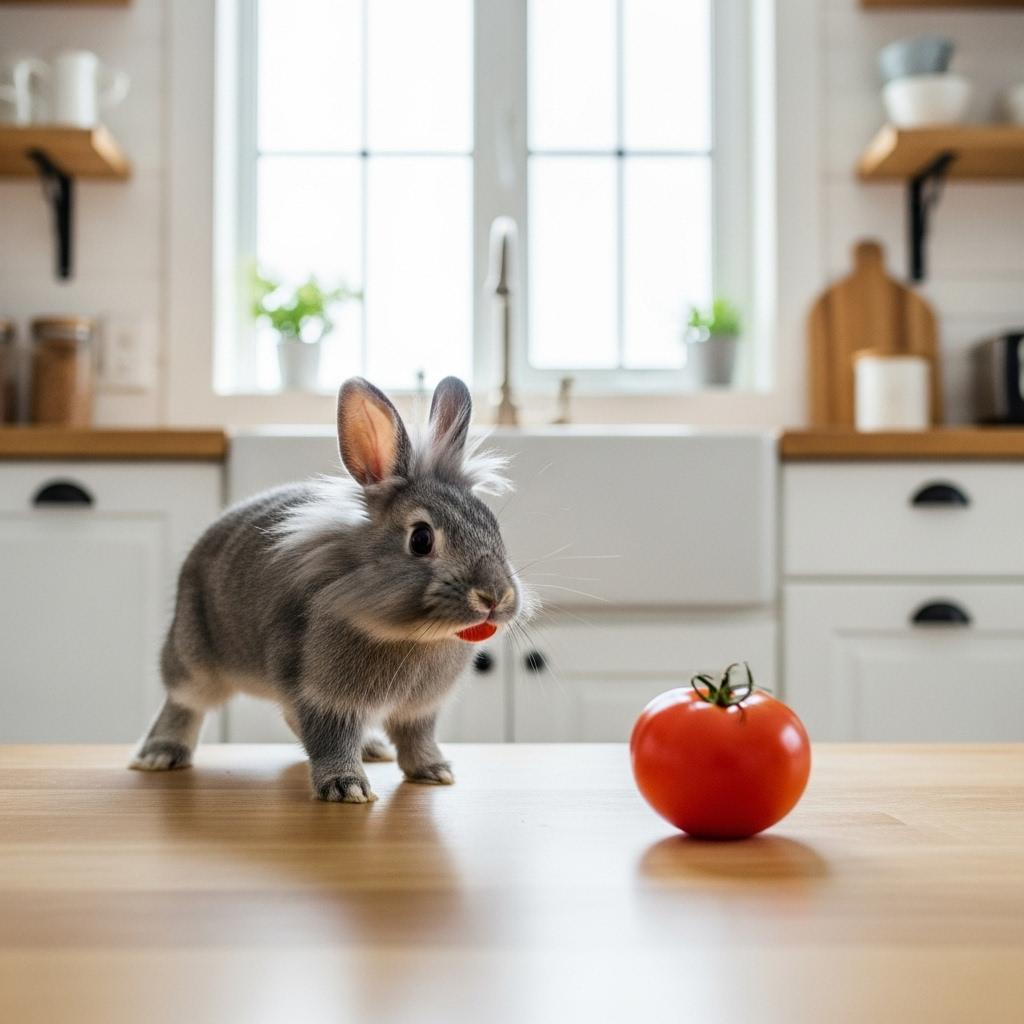

In [ ]:
import base64
import io
from PIL import Image

for prediction in response.json()['predictions']:
  if "bytesBase64Encoded" in prediction:
    decoded_bytes = base64.b64decode(prediction["bytesBase64Encoded"])
    # Create an in-memory file-like object from the decoded bytes
    image_buffer = io.BytesIO(decoded_bytes)
    # Load the image using PIL
    display(img := Image.open(image_buffer))
    print(img.size)

## Next Steps
### Useful documentation references:

To improve your prompting skills, check the [prompt guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide) for great advices on creating your prompts.

### Check those cool Imagen examples:
These examples are in Python but they will still give you ideas on how to use Imagen in creative ways:
*  [Illustrate a book](../examples/Book_illustration.ipynb): Use Gemini and Imagen to create illustration for an open-source book

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding](./Video_understanding.ipynb) one for video examples.
